In [1]:
from model_utils import *

In [2]:
FILE = "./data/filtered_elmundo.json"
DATASET_NAME = 'elmundo'
LOG_DIR = "./news-classification"
MAX_CATE_SIZE = 3000
MODEL_NAME = 'skimai/spanberta-base-cased'
MAX_SEQ_LENGTH = 128
BATCH_SIZE = 128
LEARN_RATE = 4e-5
EPOCH = 6
TASK = 'further_pretrained'

In [3]:
import datetime
today = datetime.date.today().strftime("%m%d")
RESULT_DIR = 'results/{}-results-{}'.format(TASK,today)
SUB_DIR = '/{}-{}'.format(LEARN_RATE, MAX_SEQ_LENGTH)
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)
if not os.path.exists("{}{}".format(RESULT_DIR,SUB_DIR)):
    os.makedirs("{}{}".format(RESULT_DIR,SUB_DIR))
OUTPUT_PATH = RESULT_DIR + SUB_DIR

In [4]:
# classifier label set

target_label = ['economia',  # economic
              'internacional',  # international
              'deportes',  # sports
              'cultura',  # culture
              'television',  # television
              'ciencia-y-salud',  # science and health
              'tecnologia',  # technology
               ]
# source item label set
source_label = ['economia',  # economic
              'internacional',  # international
              'deportes',  # sports
              'cultura',  # culture
              'television',  # television
              'ciencia-y-salud',  # science and health
              'tecnologia',  # technology
               ]
source_label_dic = {}
for idx, label in enumerate(source_label):
    source_label_dic[label] = idx

## Load Data

In [5]:
def load_test_data(path,cate_size,type='JSON',percentage=1):
    if type == "JSON":
        df = pd.read_json(path)
    else:
        df = pd.read_csv(path)
    df = df.iloc[np.random.permutation(len(df))]
    df.describe()
    labels = df['category'].tolist()
    titles = df['title'].tolist()
    stand_first = df['stand_first'].tolist()
    contents = df['content'].tolist()
    contents = [h + s + d for h, s, d in zip(titles, stand_first, contents)]
    label_dic = {}
    final_size = int(len(contents) * percentage)
    if percentage != 1:
        contents = contents[:final_size]
        labels = labels[:final_size]

    # itos                                        
    label_set = ['WORLD NEWS', 'ARTS & CULTURE', 'WEDDINGS', 'PARENTING',
                 'BUSINESS & FINANCES', 'HOME & LIVING', 'EDUCATION',
                 'WELLNESS', 'POLITICS', 'WOMEN', 'IMPACT', 'ENVIRONMENT',
                 'SPORTS', 'FOOD & DRINK', 'GROUPS VOICES', 'MEDIA',
                 'SCIENCE & TECH', 'CRIME', 'WEIRD NEWS', 'COMEDY',
                 'RELIGION', 'MISCELLANEOUS', 'DIVORCE', 'ENTERTAINMENT',
                 'STYLE & BEAUTY', 'TRAVEL']
    # stoi
    for idx, label in enumerate(label_set):
        label_dic[label] = idx
    """
    label_count = {}
    flitered_labels = []
    flitered_contents = []
    for cate, cont in zip(labels, contents):
        if cate not in label_count.keys():
            label_count[cate] = 1
            flitered_labels.append(cate)
            flitered_contents.append(cont)
        elif label_count[cate] < cate_size:
            label_count[cate] += 1
            flitered_labels.append(cate)
            flitered_contents.append(cont)
    
    """
    # shuffle
    idx_list = list(range(0, len(labels), 1))
    random.shuffle(idx_list)
    shuffled_labels = []
    shuffled_contents = []
    for idp in idx_list:
        shuffled_labels.append(labels[idp])
        shuffled_contents.append(contents[idp])
    print('Data loaded label:{} content:{} '.format(len(labels), len(contents)))
    return shuffled_labels, shuffled_contents, label_set, label_dic

In [6]:
class TestDataset(Dataset):
    def __init__(self,labels,inputs,origins,ldic):
        self.labels = labels
        self.origins = origins
        self.inputs = inputs
        self.ldic = ldic
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self,idx):
        y = self.labels[idx]
        y_encoded = torch.Tensor([self.ldic.get(y,-1)]).long().squeeze(0)
        res ={
            'input_ids':self.inputs[idx]['input_ids'][0],
            'attention_mask': self.inputs[idx]['attention_mask'][0],
            'origin_contents':self.origins[idx],
            'targets':y_encoded,
        }
        return res

In [7]:
# load test data and label info
labels,contents,lset,ldic = load_test_data(FILE,MAX_CATE_SIZE)

# encode
start = time.time()
encoding_list = pre_encode_list(MODEL_NAME,contents,MAX_SEQ_LENGTH)
print("encoding time costs: {}".format(time.time()-start))

# load valid dataset 
valid_dataset = NewsCategoryDataset(labels, encoding_list, contents, source_label_dic)
train_dataset = NewsCategoryDataset(labels, encoding_list, contents, source_label_dic )
valid_dataset = NewsCategoryDataset(labels, encoding_list, contents, source_label_dic,
                                    'val')
test_dataset = NewsCategoryDataset(labels, encoding_list, contents, source_label_dic,
                                   'test')
print('data loaded \ntrain:{}\nvalid:{}\ntest:{}'.format(len(train_dataset),
                                                          len(valid_dataset),
                                                          len(test_dataset)))
      
# dataloader
train_val_loaders = {
    "train": DataLoader(dataset=train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True),
    "valid": DataLoader(dataset=valid_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False),
    "test": DataLoader(dataset=test_dataset,
                       batch_size=BATCH_SIZE,
                       shuffle=False)
}

Data loaded label:4520 content:4520 


100%|██████████| 4520/4520 [00:02<00:00, 1685.61it/s]

Tokenizer loaded...
encoding time costs: 7.7965192794799805
data loaded 
train:3164
valid:678
test:678


In [9]:
class FurtherPretrainClassifier(nn.Module):
    def __init__(self, model_name, source,target_num):
        super().__init__()
        config = RobertaConfig.from_pretrained(model_name, num_labels=target_num)
        self.model = RobertaForSequenceClassification(MODEL_NAME,len(lset))
        state_dict = torch.load(source)
        self.model.load_state_dict(state_dict)
        print(self.model.MLP)
        self.model.MLP = nn.Linear(config.hidden_size, target_num)
        self.model.MLP.apply(weight_init)

    def forward(self, features, attention_mask=None, head_mask=None):
        assert attention_mask is not None, 'attention_mask is none'
        bert_output = self.model.bert(input_ids=features,
                                attention_mask=attention_mask,
                                head_mask=head_mask)

        hidden_state = bert_output[0]

        pool_output = hidden_state[:, 0]
        # print(pool_output)
        # print(pool_output.shape)
        logits = self.model.MLP(pool_output)
        # logits.unsqueeze(1)
        return logits

In [11]:
#load model
source_dict = './results/3.699999999999999e-05-128/5-18-epoch-4.pth'
model = FurtherPretrainClassifier(MODEL_NAME,source_dict,len(source_label))

Linear(in_features=768, out_features=26, bias=True)


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LEARN_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
if torch.cuda.is_available():
    model = nn.DataParallel(model)
    model.cuda()
acclist,losslist = train_classifier(model,EPOCH,LEARN_RATE, MAX_SEQ_LENGTH,
                                    train_val_loaders,criterion,today,
                                    optimizer,scheduler, path=OUTPUT_PATH)

epoch 0


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0 batch 24, loss: 0.6902 acc: 73.913  
validating...
After Epoch 0 , valid acc: 0.7374631268436578, avg loss0.9942618083953857  avg acc0.6361277173913044
epoch 1


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 batch 24, loss: 0.6715 acc: 70.6522 
validating...
After Epoch 1 , valid acc: 0.7448377581120944, avg loss0.8073211163282394  avg acc0.705319293478261
epoch 2


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2 batch 24, loss: 0.3412 acc: 90.2174 
validating...
After Epoch 2 , valid acc: 0.7566371681415929, avg loss0.6711058197418849  avg acc0.7564085144927536
epoch 3


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3 batch 24, loss: 0.2355 acc: 92.3913 
validating...
After Epoch 3 , valid acc: 0.7551622418879056, avg loss0.5712107306718827  avg acc0.7959205163043478
epoch 4


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4 batch 24, loss: 0.2666 acc: 93.4783  
validating...
After Epoch 4 , valid acc: 0.7625368731563422, avg loss0.48737606799602506  avg acc0.8274021739130435
epoch 5


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5 batch 24, loss: 0.09492 acc: 97.8261 
validating...
After Epoch 5 , valid acc: 0.7713864306784661, avg loss0.4190443898861607  avg acc0.8525339673913045


## Acc and loss

In [13]:
import matplotlib.pyplot as plt
batch_step = 50
new_acc = acclist[0::batch_step]
new_loss = losslist[0::batch_step]

x_label = [i*batch_step for i in range(len(new_acc))]
new_acc = [np.mean(np.array(acclist[i*batch_step:(i+1)*batch_step])) for i in range(len(new_acc))]
loss_acc = [np.mean(np.array(losslist[i*batch_step:(i+1)*batch_step])) for i in range(len(new_loss))]

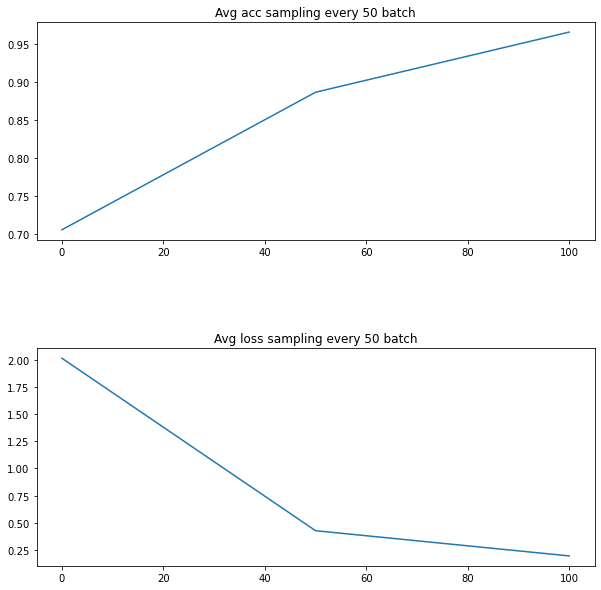

<Figure size 432x288 with 0 Axes>

In [14]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(2,1,1,)
ax1.plot(x_label,new_acc)
ax1.set_title('Avg acc sampling every {} batch'.format(batch_step))
ax2 = plt.subplot(2,1,2,sharex=ax1)
ax2.plot(x_label,new_loss)
ax2.set_title('Avg loss sampling every {} batch'.format(batch_step))
plt.subplots_adjust(wspace =0, hspace =0.5)
plt.show()
plt.savefig('./img/{}-{}-acc-loss.jpg'.format(LEARN_RATE,MAX_SEQ_LENGTH))

In [15]:
#visualization
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
iterator = train_val_loaders
true_labels = []
pred_labels = []

model.eval()
tkz = AutoTokenizer.from_pretrained(MODEL_NAME)
with torch.no_grad():
    for ba,data in enumerate(notetqdm(iterator['valid'])):
        features = data['input_ids'].cuda()
        att_mask = data['attention_mask'].cuda()
        targets = data['targets']
        origins = data['origin_contents']
        targets.numpy()
        # print(len(origins), len(targets))
        true_labels += targets.tolist()
        outputs = model(features,att_mask)
        outputs = outputs.cpu().detach().numpy()
        outputs = np.argmax(outputs, axis=1)
        # print screen 
        # print(len(data))
        for i in range(len(origins)):
            print("idx:{}".format(i))
            print(origins[i])
            print('pred: ',target_label[outputs[i]])
            print('true: ',source_label[targets[i]])
            print('--------------')
        pred_labels += outputs.tolist()
    print(len(true_labels))
    print(true_labels[:15])
    print(len(pred_labels))
    print(pred_labels[:15])
        

  0%|          | 0/6 [00:00<?, ?it/s]

idx:0
Más de 1.700 inmigrantes muertos al tratar de llegar a España en el último añoDerechos Humanos advierte que en 2020 hubo récord de fallecidos pese a la pandemiaLos inmigrantes que se embarcan en pateras en el norte de África y tratan de alcanzar las costas andaluzas se juegan la vida en la travesía. Desde el pasado fin de semana, han sido hallados nueve cadáveres, entre ellos el de un niño de entre 3 y 4 años, en varias playas de Almería. Y no se trata, ni mucho menos, de un hecho aislado.
pred:  economia
true:  cultura
--------------
idx:1
Las lágrimas de emoción del MVP Llull en el lugar donde todo cambió: "Han sido años duros"El balear (24 puntos), rompió a llorar tras la conquista de la Supercopa en el Santiago Martín, donde hace cuatro años se rompió los ligamentos de la rodillaA Sergio Llull se le recuerdan gestos de rabia, arrebatos de genialidad, abrazos de compañerismo e incluso algún enfado de campeonato. A Llull se le vio tantas veces reír, tantas gritar, tantas espole

idx:0
Muere el popular Gonzalito, eterno mozo de espadas de Curro RomeroNacido en la localidad onubense de Gibraleón hace 89 años, Gonzalito era uno de los taurinos más queridos y respetadosEl popular hombre del toro Gonzalo Sánchez Conde, que durante más de treinta años fue mozo de espadas de Curro Romero, ha sido encontrado muerto a primeras horas de esta mañana en su domicilio del madrileño barrio de Las Letras.
pred:  cultura
true:  cultura
--------------
idx:1
Ante la tensión en la pista, un ejemplo universal de control: Rafa NadalQue Djokovic es genio y figura no hay ninguna duda, sólo hay que ver su palmarés. Que es pasional e imprevisible pero también humano y educado lo demuestran muchos gestos que ha tenido en su carrera, tiernos, solidarios. Por ejemplo, sin mirar muy atrás, el del pasado domingo: al despedirse dando la mano a su rival Pablo Carreño tras ser descalificado en el US Open. Un adiós inesperado y estrambótico. Increíble pero cierto. Que su acción en el US Open ha

idx:0
8 tiendas de discos en Madrid a las que debes ir si eres amante de los vinilosLa venta de vinilos no para de crecer. Son muchos los que en esta era digital aún prefieren escuchar música como se hacía hace 40 años: desenfundando un disco y haciéndolo girar en un tocadiscos. Según la Asociación de Industria Discográfica de Estados Unidos (RIAA), las ventas de vinilos han superado a la de CDs en el país americano durante el primer semestre de 2020, 232,1 millones de euros frente a 129,9 millones. Es la primera vez que ocurre esto desde la comercialización universal de los discos compactos en la década de los 80. Esta tendencia también se está viviendo en España, donde el famoso elepé representa ya el 40% de las ventas musicales en formato físico.
pred:  economia
true:  cultura
--------------
idx:1
10 buenos móviles por menos de 200 euros para empezar el curso con buen pieHacerse con un buen móvil no es sinónimo de tener que gastarse casi 1.000 eurosHay dos tipos de móviles que triun

idx:0
La nueva tecnología de Nvidia convierte tus fotos en objetos en tres dimensionesDe momento sólo funciona con coches, pero tienen pensado desarrollarla para que una simple fotografía sirva como modelo para generar una imagen tridimensionalNvidia está desarrollando una tecnología que, haciendo uso de inteligencia artificial y potentes algoritmos que interpretan imágenes, permite convertir la fotografía de un coche en un modelo en tres dimensiones del mismo. 
pred:  tecnologia
true:  tecnologia
--------------
idx:1
Daniel Gascón: "¿Guerras culturales? Nos gusta mucho poner nombres diferentes a las cosas de siempre"'La muerte del hispter' lleva al Bajo Aragón los pequeños y grandes dramas de un mundo ensimismado, 'veggie' y tontamente moderno. Daniel Gascón gusta de citar la siguiente frase de Woody Allen: «Los intelectuales son como la mafia: sólo se matan entre ellos». Lo hace con regusto irónico: él mismo dice que «hoy se debate más sobre los debates que acerca de ninguna otra cos

idx:0
La crisis financiera de China más allá de la caída de EvergrandeEl sector inmobiliario representa alrededor de una cuarta parte de la economía china según algunas métricasEvergrande, episodio 150 millones. Esos son los dólares que el endeudado promotor chino no abonó en su tercera ronda de pagos que el lunes vencía. Su crisis sigue intensificando los temores del mercado sobre el contagio a otros gigantes inmobiliarios
pred:  economia
true:  economia
--------------
idx:1
La Ley de Vivienda se enquista mientras UP presiona para imponer el modelo catalánLa norma acumula ya casi ocho meses de retraso en su aprobación y el diálogo está congelado. No ha habido reuniones en los últimos casi tres meses y no hay una fecha próxima prevista sobre la mesaOcho meses de retraso y los últimos tres con el diálogo congelado es el balance de las negociaciones por la Ley de Vivienda, cuyo futuro cada vez es más difuso pese a que tanto PSOE como Unidas Podemos la anunciaron como uno de sus proyectos

idx:0
Una dieta de una semana para acabar con la retención de líquidos y perder dos kilosPues sí, resulta que para evitar la retención de líquidos y las piernas hinchadas lo mejor que podemos hacer es, precisamente, tomar muchos líquidos, en concreto agua, tés y bebidas saludables como zumos naturales de frutas sin añadirles azúcar o incluso nuestra sopa fría más veraniega, el gazpacho (sin pan y con la cantidad justa de aceite).
pred:  deportes
true:  deportes
--------------
idx:1
Mueren dos escaladores que practicaban 'psicobloc' sobre el mar en un acantilado de la costa de MallorcaEran norteamericanos y tenían 25 y 35 años. Cayeron tras un desprendimiento de rocas.Dos hombres de 25 y 35 años de edad y de nacionalidad estadouniense han aparecido muertos flotando en las aguas que bañan los acantilados del sureste de Mallorca, en una zona muy frecuentada por los amantes del 'psicobloc', una modalidad extrema de escalada libre que se practica sobre el mar.
pred:  economia
true:  economi

7 7


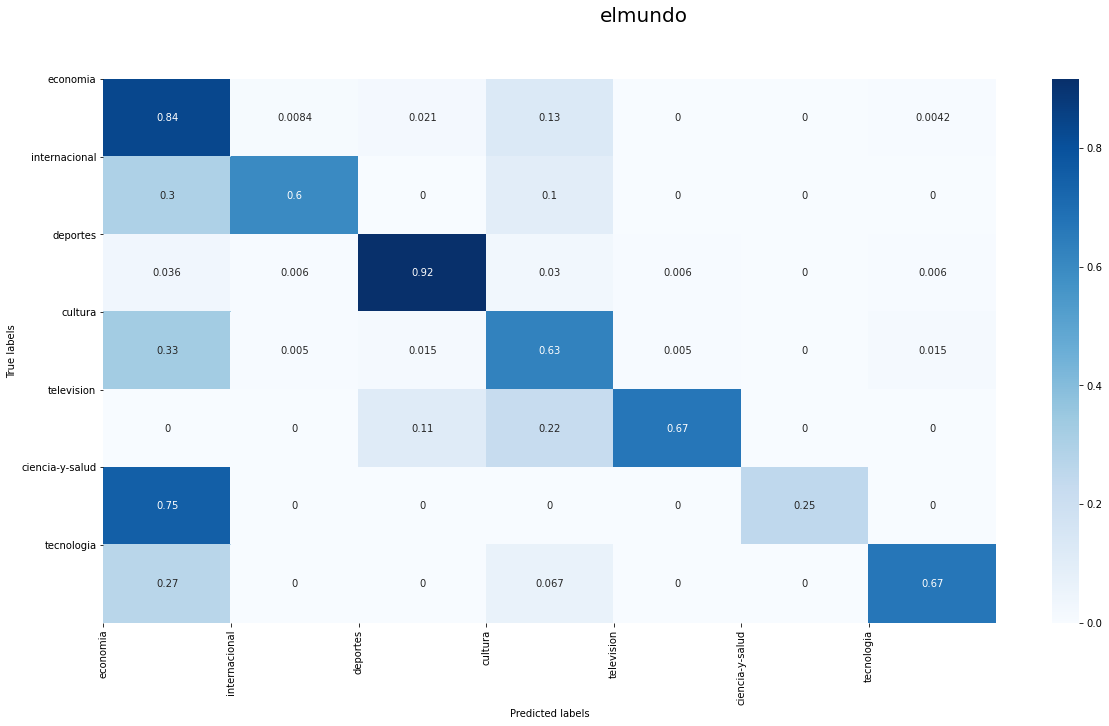

In [17]:
true_cate = [source_label[i] for i in true_labels]
pred_cate = [target_label[j] for j in pred_labels]

con_mat = confusion_matrix(true_cate,pred_cate)
con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]     # nomalization
con_mat_norm = np.around(con_mat_norm, decimals=2)

# =====diy confusion matrix=====
matrix = [[0 for i in range(len(target_label))] for j in range(len(source_label))]
print(len(matrix),len(matrix[0]))
sums = [0 for i in range(len(source_label))]
for x,y in  zip(true_labels,pred_labels):
    matrix[x][y] += 1
    sums[x] += 1
# normalization
for i in range(len(source_label)):
    for j in range(len(target_label)):
        matrix[i][j] /= sums[i]
    
# === plot ===
fig = plt.figure(figsize=(20, 10))
sns.heatmap(matrix, annot=True, cmap='Blues')
catex = list(range(0,len(target_label),1))
catey = list(range(0,len(source_label),1))
fig.suptitle('elmundo',fontsize=20)

plt.xlabel('Predicted labels')
plt.xticks(catex,target_label)
plt.xticks(rotation=90)

plt.ylabel('True labels')
plt.yticks(catey,source_label)
plt.yticks(rotation=360)
plt.show()
# plt.savefig('./img/{}-{}-matrix.jpg'.format(init_lr,MAX_SEQ_LENGTH))